In [26]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# OBSERVADOR DE ESTADO DE ORDEM MÍNIMA

In [27]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [28]:
s = ctl.TransferFunction.s

G = 0.025/(0.15560577*s**2 - 0.78893795*s + 1.0)
G

TransferFunction(array([0.025]), array([ 0.15560577, -0.78893795,  1.        ]))

polos:  (2.535+0j) (2.535+0j)
zeros: 


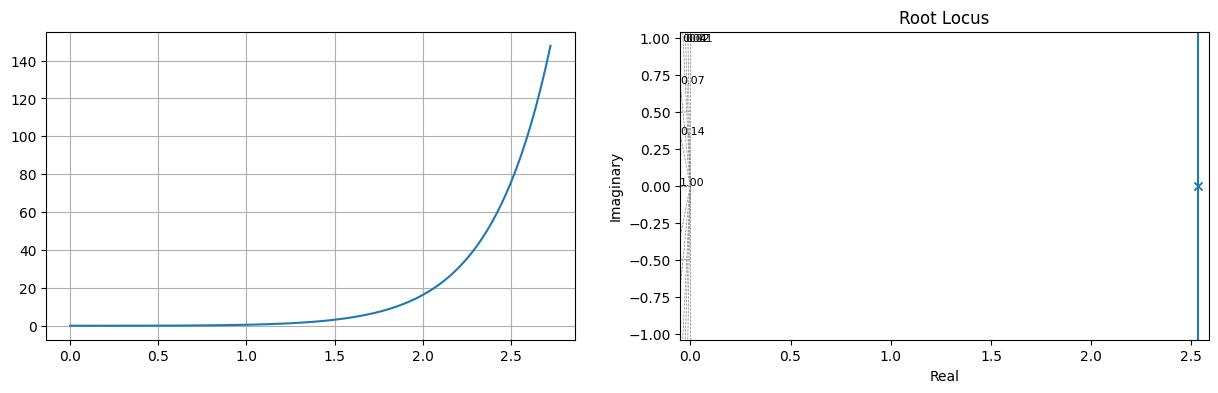

In [29]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# REQUISITOS DE CONTROLE

In [30]:
Ts = 20.00
UP = 0.30

- $\zeta = -\frac{ln(UP\%)}{\sqrt{\pi² + ln²(UP\%)}}$

In [31]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.35785713050331663

- $\omega_n = \frac{4}{\zeta\,t_s}$ 

In [32]:
Wn = 4/(zeta*Ts)
Wn

0.5588822548224909

- $s_d = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [33]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*1j
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*1j
s3 = -15                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s4 = -15                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s5 = -15                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)

p = [np.round(val, 3) for val in [s1, s2]]
p

[(-0.2+0.522j), (-0.2-0.522j)]

# ESPAÇO DE ESTADOS
- Forma padrão (computacional)

In [34]:
matrix = ctl.tf2ss(G)
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[5.07010729743505, -6.4264969094655],
[             1.0,                0]])

Matrix([
[1.0],
[  0]])

Matrix([[0, 0.160662422736638]])

Matrix([[0]])

- Forma variáveis de fase (convencional)

In [35]:
def getVariaveisFase(G):
    matrix = ctl.tf2ss(G)
    A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
    
    n = A.shape[0]

    # Cria uma matriz P com elementos 1 na diagonal secundária
    P = np.fliplr(np.eye(n))

    # Calcula a inversa da matriz P
    P_inv = np.linalg.inv(P)

    # Realiza as operações para obter a forma de variáveis de fase
    A = P_inv @ A @ P
    B = P_inv @ B
    C = C @ P
    D = D
    
    return A, B, C, D

A, B, C, D = getVariaveisFase(G)
display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[               0,              1.0],
[-6.4264969094655, 5.07010729743505]])

Matrix([
[  0],
[1.0]])

Matrix([[0.160662422736638, 0]])

Matrix([[0]])

In [36]:
A_aa = np.array([A[0, 0]])
A_ab = np.array([A[0, 1:]])
A_ba = np.array(A[1:, 0])
A_bb = np.array(A[1:, 1:])

B_a = np.array([B[0, 0]])
B_b = np.array(B[1:, 0])

display(sp.Matrix(A_aa))
display(sp.Matrix(A_ab))
display(sp.Matrix(A_ba))
display(sp.Matrix(A_bb))
display(sp.Matrix(B_a))
display(sp.Matrix(B_b))

Matrix([[0]])

Matrix([[1.0]])

Matrix([[-6.4264969094655]])

Matrix([[5.07010729743505]])

Matrix([[0]])

Matrix([[1.0]])

In [37]:
n = sp.shape(A_bb)[0]
n

1

# CONTROLADOR

In [38]:
K = ctl.acker(A, B, p)
#K = ctl.place(A, B, p)

sp.Matrix(K)

Matrix([[-6.1140129094655, 5.47010729743505]])

In [39]:
L = ctl.acker(A_bb.T, A_ab.T, p).T
#L = ctl.place(A_bb.T, A_ab.T, p).T

L = sp.Matrix(L)
L

Matrix([[28.0465149264782]])

In [40]:
s = sp.symbols('s')
I = sp.eye(n) 

A_aa, A_ab, A_ba, A_bb = sp.Matrix(A_aa), sp.Matrix(A_ab), sp.Matrix(A_ba), sp.Matrix(A_bb)
B_a, B_b = sp.Matrix(B_a), sp.Matrix(B_b)

A, B, C, D = sp.Matrix(A), sp.Matrix(B), sp.Matrix(C), sp.Matrix(D)

### CONSTANTES

As constantes do vetor de ganhos K são:

- $\boldsymbol{K_a} = \boldsymbol{K}[1]$
- $\boldsymbol{K_b} = \boldsymbol{K}[2:]$

As constantes das matrizes chapéu são:

- $\boldsymbol{\hat{A}} = \boldsymbol{Abb} - \boldsymbol{L}\,\boldsymbol{Aab}$
- $\boldsymbol{\hat{B}} = \boldsymbol{\hat{A}}\,\boldsymbol{L}+\boldsymbol{Aba}-\boldsymbol{L}\,\boldsymbol{Aaa}$
- $\boldsymbol{\hat{F}} = \boldsymbol{Bb} - \boldsymbol{L}\,\boldsymbol{Ba}$

As constantes das matrizes til são:

- $\boldsymbol{\tilde{A}} = \boldsymbol{\hat{A}} - \boldsymbol{\hat{F}}\,\boldsymbol{Kb}$
- $\boldsymbol{\tilde{B}} = \boldsymbol{\hat{B}} - \boldsymbol{\hat{F}}\,\boldsymbol{Ka}$
- $\boldsymbol{\tilde{C}} = \boldsymbol{-Kb}$
- $\boldsymbol{\tilde{D}} = -(\boldsymbol{Ka}+\boldsymbol{Kb}\,\boldsymbol{L})$

In [41]:
Ka = sp.Matrix([K[0][0]])
Kb = sp.Matrix(np.array([K[0][1:]]))

display(Ka)
display(Kb)

Matrix([[-6.1140129094655]])

Matrix([[5.47010729743505]])

In [42]:
Ahat = A_bb - L*A_ab
Bhat = Ahat*L + A_ba - L*A_aa
Fhat = B_b - L*B_a

display(Ahat)
display(Bhat)
display(Fhat)

Matrix([[-22.9764076290431]])

Matrix([[-650.83465643427]])

Matrix([[1.0]])

In [43]:
Atil = Ahat - Fhat*Kb
Btil = Bhat - Fhat*Ka
Ctil = -Kb
Dtil = -(Ka + Kb*L)

display(Atil)
display(Btil)
display(Ctil)
display(Dtil)

Matrix([[-28.4465149264782]])

Matrix([[-644.720643524805]])

Matrix([[-5.47010729743505]])

Matrix([[-147.303433057484]])

- O controlador é obtido usando $C(s) = -[\boldsymbol{\tilde{C}}\,(s\boldsymbol{I} - \boldsymbol{\tilde{A}})^{-1}\,\boldsymbol{\tilde{B}} + \boldsymbol{\tilde{D}}]$

In [44]:
C = -(Ctil*(s*I - Atil).inv()*Btil + Dtil)
C = C[0].expand().simplify().factor().cancel()
C = roundSympyFunction(C)
C

(5.1783*s + 23.3272)/(0.0352*s + 1.0)

# RESPOSTA CONTROLADA

In [45]:
s = ctl.TransferFunction.s
C = eval(str(C))
C

TransferFunction(array([ 5.1783, 23.3272]), array([0.0352, 1.    ]))

In [46]:
G_ma = G*C
G_ma

TransferFunction(array([0.1294575, 0.58318  ]), array([ 0.00547732,  0.12783515, -0.75373795,  1.        ]))

In [47]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([0.1294575, 0.58318  ]), array([ 0.00547732,  0.12783515, -0.62428045,  1.58318   ]))

polos:  (-27.811+0j) (2.236+2.322j) (2.236-2.322j)
zeros:  (-4.505+0j)


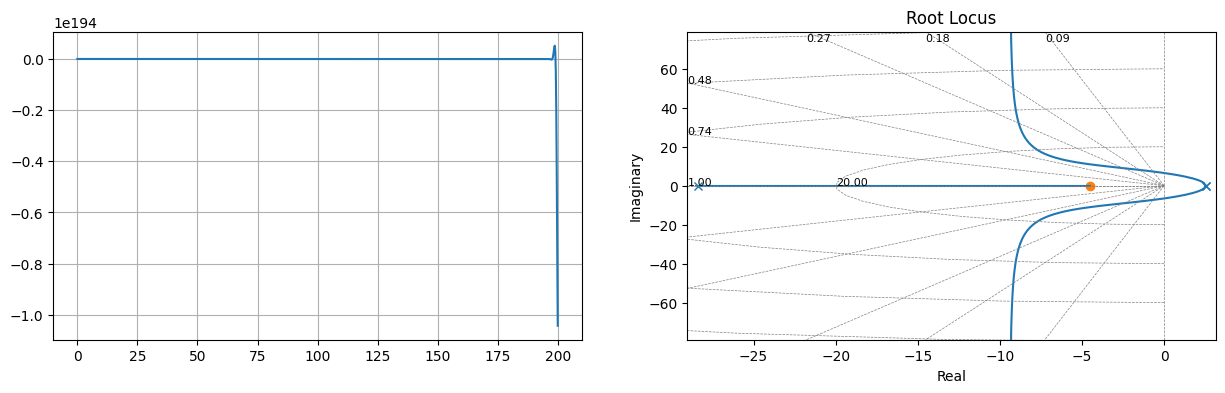

In [48]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G_feedback, T=np.linspace(0, 10*Ts, 1000))
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [53]:
print(sympyFunction(C))

(5.1783*s + 23.3272)/(0.0352*s + 1.0)


In [49]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  inf
valor de pico:  5.180343888388141e+192
tempo de pico:  198.7987987987988
tempo de assentamento:  None
valor final:  -1.0430009958715893e+194
erro:  1.0430009958715893e+194


# APLICANDO VÁRIOS STEPS

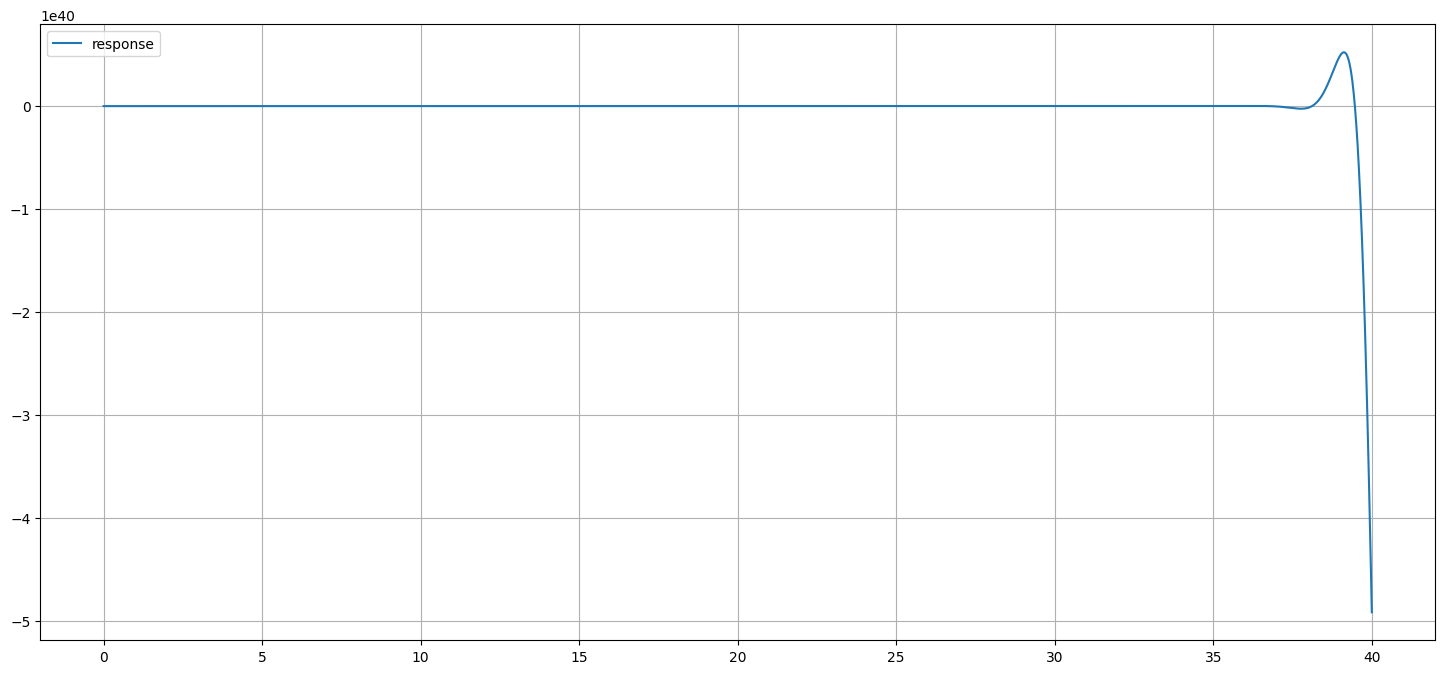

In [50]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()